# Step 1: Import Libraries
Load the necessary libraries for Spark and geospatial data processing.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, col, broadcast, udf, lead, when, sum as spark_sum
from pyspark.sql.window import Window
import json
from shapely.geometry import shape, Point
from pyspark.sql.types import StringType
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Step 2: Initialize Spark Session
Create a Spark session to work with the data.

In [2]:
spark = SparkSession.builder \
    .appName("NYC Taxi Utilization Analysis") \
    .getOrCreate()

#Step 3: Load Taxi Data (CSV) and Initial Preprocessing
Load the taxi data from a CSV file and preprocess it by filtering out invalid coordinates and null values.

In [3]:
# Load the taxi data from a CSV file
df = spark.read.csv("/content/Sample NYC Data.csv", header=True, inferSchema=True)

In [4]:
df.count()

99999

In [5]:
df.show(5)

+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N| 01-01-13 15:11|  01-01-13 15:18|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|                 N| 06-01-13 00:18|  06-01-13 00:22|              1|      -74.006683|      40.731781|       -73.994499|        40.75066|


In [6]:
# Describe statistics of latitude and longitude columns
df.select("dropoff_latitude", "dropoff_longitude", "pickup_latitude", "pickup_longitude").describe().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|  dropoff_latitude| dropoff_longitude|  pickup_latitude|  pickup_longitude|
+-------+------------------+------------------+-----------------+------------------+
|  count|             99999|             99999|            99999|             99999|
|   mean|39.922430157541406|-72.55315789447785|40.04864264028629|-72.65573395207942|
| stddev|14.806522846564748|10.154353044728792|5.795547771378345| 9.784012203735806|
|    min|        -3113.7888|        -95.650002|              0.0|        -98.116669|
|    max|         652.72314|               0.0|        646.43829|               0.0|
+-------+------------------+------------------+-----------------+------------------+



In [7]:
# Change format to timestamp
df = df.withColumn("pickup_datetime", to_timestamp("pickup_datetime", "dd-MM-yy HH:mm"))
df = df.withColumn("dropoff_datetime", to_timestamp("dropoff_datetime", "dd-MM-yy HH:mm"))

# Filter out rows with null values in pickup and dropoff columns
df = df.dropna(subset=["medallion", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"])
df = df.filter(df["passenger_count"] != 0)
# Filter based on reasonable coordinate boundaries (NYC region)
df = df.filter((df["pickup_longitude"] <= -73) & (df["pickup_longitude"] >= -74.5) &
               (df["pickup_latitude"] >= 40) & (df["pickup_latitude"] <= 41.5) &
               (df["dropoff_longitude"] <= -73) & (df["dropoff_longitude"] >= -74.5) &
               (df["dropoff_latitude"] >= 40) & (df["dropoff_latitude"] <= 41.5))

# Removing non column 'store_and_fwd_flag'
df = df.drop("store_and_fwd_flag")

In [8]:
# Describe statistics of latitude and longitude columns
df.select("dropoff_latitude", "dropoff_longitude", "pickup_latitude", "pickup_longitude").describe().show()

+-------+-------------------+-------------------+-------------------+--------------------+
|summary|   dropoff_latitude|  dropoff_longitude|    pickup_latitude|    pickup_longitude|
+-------+-------------------+-------------------+-------------------+--------------------+
|  count|              98003|              98003|              98003|               98003|
|   mean|    40.752478190494| -73.97385781438311| 40.752180583206545|  -73.97310213963833|
| stddev|0.03010826584752796|0.03704891145019836|0.02859341371439386|0.037595306021660196|
|    min|          40.447166|         -74.422424|          40.447166|          -74.422424|
|    max|          41.252129|              -73.0|          41.349998|          -73.000938|
+-------+-------------------+-------------------+-------------------+--------------------+



In [9]:
# Check the number of remaining rows after perprocessing
print("Remaining rows after perprocessing:", df.count())

Remaining rows after perprocessing: 98003


#Step 4: Load GeoJSON Data and Prepare Borough Polygons
Load the GeoJSON file containing borough boundaries, create Shapely polygons for each borough, and sort by borough code and polygon area.

In [10]:
# Load GeoJSON data
with open('nyc-boroughs.geojson', 'r') as f:
    geojson_data = json.load(f)

# Process each feature to extract borough boundaries
borough_polygons = []
for feature in geojson_data['features']:
    polygon = shape(feature['geometry'])
    borough_name = feature['properties']['borough']
    borough_code = feature['properties']['boroughCode']
    borough_polygons.append((borough_name, borough_code, polygon))

# Sort by borough code and polygon area
borough_polygons.sort(key=lambda x: (x[1], -x[2].area))

# Broadcast borough data to all workers
broadcast_boroughs = spark.sparkContext.broadcast(borough_polygons)

#Step 5: Define UDF to Assign Boroughs Based on Coordinates
Define a UDF that takes longitude and latitude coordinates, creates a point, and checks if it falls within any borough polygon.

In [11]:
# Define UDF to assign borough based on coordinates
def get_borough(longitude, latitude):
    point = Point(longitude, latitude)
    for borough_name, borough_code, polygon in broadcast_boroughs.value:
        if polygon.contains(point):
            return borough_name
    return None

# Register UDF
get_borough_udf = udf(get_borough, StringType())

# Add pickup and dropoff borough columns
df = df.withColumn("pickup_borough", get_borough_udf(df["pickup_longitude"], df["pickup_latitude"]))
df = df.withColumn("dropoff_borough", get_borough_udf(df["dropoff_longitude"], df["dropoff_latitude"]))

In [12]:
df.show(5)

+--------------------+--------------------+---------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+--------------+---------------+
|           medallion|        hack_license|vendor_id|rate_code|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|pickup_borough|dropoff_borough|
+--------------------+--------------------+---------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+--------------+---------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|2013-01-01 15:11:00|2013-01-01 15:18:00|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|     Manhattan|      Manhattan|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|2013-01-06 00:18:00|2013-01-06 00:22:00|              1|     

#Step 6: Filter Out Invalid Trips and Calculate Trip Duration
Calculate the trip duration for each record and filter out invalid or unreasonable trip times.

In [13]:
# Calculate Trip Duration for Each Ride
df = df.withColumn(
    "trip_duration",
    (unix_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss") - unix_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
)


In [14]:
df.show(5)

+--------------------+--------------------+---------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+--------------+---------------+-------------+
|           medallion|        hack_license|vendor_id|rate_code|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|pickup_borough|dropoff_borough|trip_duration|
+--------------------+--------------------+---------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+--------------+---------------+-------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|2013-01-01 15:11:00|2013-01-01 15:18:00|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|     Manhattan|      Manhattan|          420|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|2013-

In [15]:
# Filter trips with valid duration
df = df.filter((col("trip_duration") > 0) & (col("trip_duration") <= 14400))

# Check the number of remaining rows after filtering
print("Remaining rows after filtering:", df.count())

Remaining rows after filtering: 97863


#Step 7: Calculate Idle Time and Compute Utilization
Use a window function to calculate idle time for each driver based on the time between consecutive trips. Then, calculate total idle time to assess utilization.

In [16]:
# Define window specification based on taxi ID and pickup time
window_spec = Window.partitionBy("medallion").orderBy("pickup_datetime")

# Calculate idle time between consecutive trips
df = df.withColumn("next_pickup", lead("pickup_datetime").over(window_spec))
df = df.withColumn("idle_time",
                   when((unix_timestamp("next_pickup") - unix_timestamp("dropoff_datetime")) <= 14400,
                        (unix_timestamp("next_pickup") - unix_timestamp("dropoff_datetime"))).otherwise(0))

# Sum idle time per taxi to get total idle time
utilization_df = df.groupBy("medallion").agg(spark_sum("idle_time").alias("total_idle_time"))
utilization_df.show()

+--------------------+---------------+
|           medallion|total_idle_time|
+--------------------+---------------+
|000318C2E3E638158...|           7200|
|002B4CFC5B8920A87...|          17700|
|002E3B405B6ABEA23...|          16140|
|0030AD2648D81EE87...|            720|
|0035520A854E4F276...|          14880|
|0036961468659D0BF...|          19740|
|003889E315BFDD985...|           9480|
|0038EF45118925A51...|          15120|
|003D87DB553C6F00F...|          12180|
|003EEA559FA618008...|          38640|
|0053334C798EC6C8E...|          22440|
|005DED7D6E6C45441...|          11760|
|005F00B38F46E2100...|          42180|
|0067C755A2988CB8F...|              0|
|00790C7BAD30B7A9E...|          25320|
|0081EFFCBB2AD30F9...|          20340|
|00891E0B23CDA09C3...|           9960|
|0094A03FFE6BAFBE0...|           5400|
|009D3CCA83486B03F...|          40920|
|009E68CADCB1BCF73...|              0|
+--------------------+---------------+
only showing top 20 rows



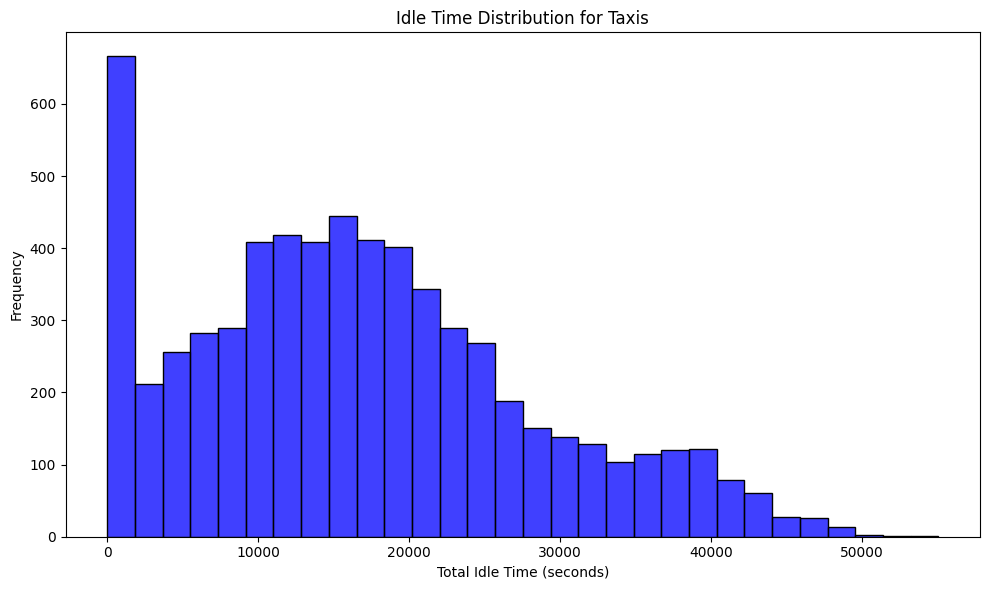

In [25]:
# Convert Spark DataFrame to Pandas DataFrame
idle_time_pd = utilization_df.toPandas()

# Plot histogram of idle times
plt.figure(figsize=(10, 6))
sns.histplot(idle_time_pd['total_idle_time'], bins=30, kde=False, color='blue')
plt.title('Idle Time Distribution for Taxis')
plt.xlabel('Total Idle Time (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#Step 8: Additional Queries for Analysis
After enriching the dataset with borough information, you can run additional queries. Here are some examples:

Total Trip Duration by Borough

In [17]:
# Total trip duration by pickup borough
trip_duration_by_borough = df.groupBy("pickup_borough").agg(spark_sum("trip_duration").alias("total_trip_duration"))
trip_duration_by_borough.show()

+--------------+-------------------+
|pickup_borough|total_trip_duration|
+--------------+-------------------+
|        Queens|            7982100|
|          NULL|              84240|
|      Brooklyn|            1811880|
| Staten Island|               2820|
|     Manhattan|           54075120|
|         Bronx|              48120|
+--------------+-------------------+



<ipython-input-23-1e2ff3dea161>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_borough', y='total_trip_duration', data=trip_duration_pd, palette='plasma')


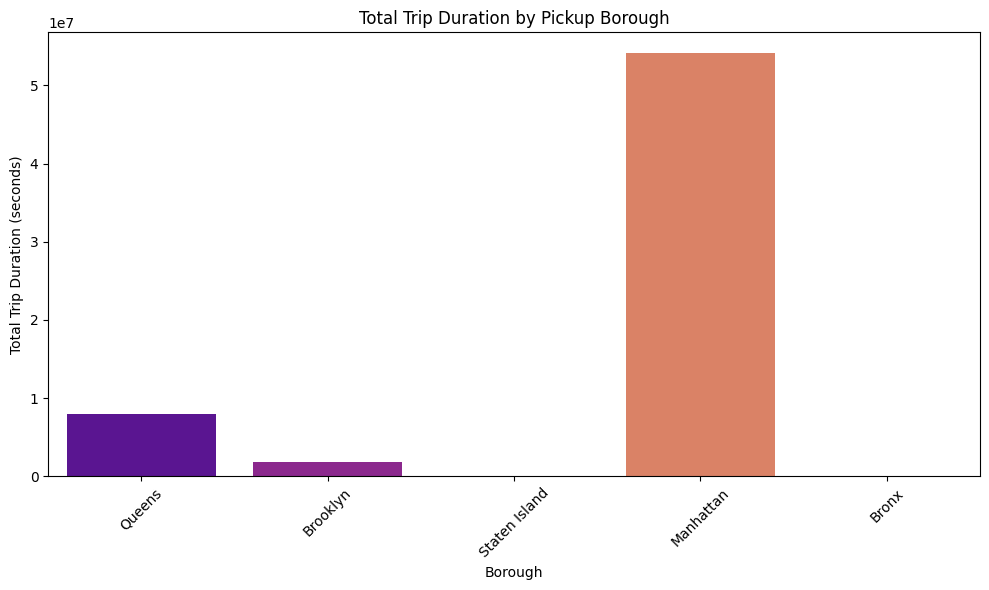

In [23]:
# Convert Spark DataFrame to Pandas DataFrame
trip_duration_pd = trip_duration_by_borough.toPandas()

# Plot the total trip duration per borough
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_borough', y='total_trip_duration', data=trip_duration_pd, palette='plasma')
plt.title('Total Trip Duration by Pickup Borough')
plt.xlabel('Borough')
plt.ylabel('Total Trip Duration (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Trip Count by Borough

In [21]:
# Trip count by pickup borough
trip_count_by_borough = df.groupBy("pickup_borough").count().withColumnRenamed("count", "trip_count")
trip_count_by_borough.show()

+--------------+----------+
|pickup_borough|trip_count|
+--------------+----------+
|        Queens|      5838|
|          NULL|       128|
|      Brooklyn|      1958|
| Staten Island|         2|
|     Manhattan|     89858|
|         Bronx|        79|
+--------------+----------+



<ipython-input-22-e9c44f0ac4ea>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_borough', y='trip_count', data=trip_count_pd, palette='viridis')


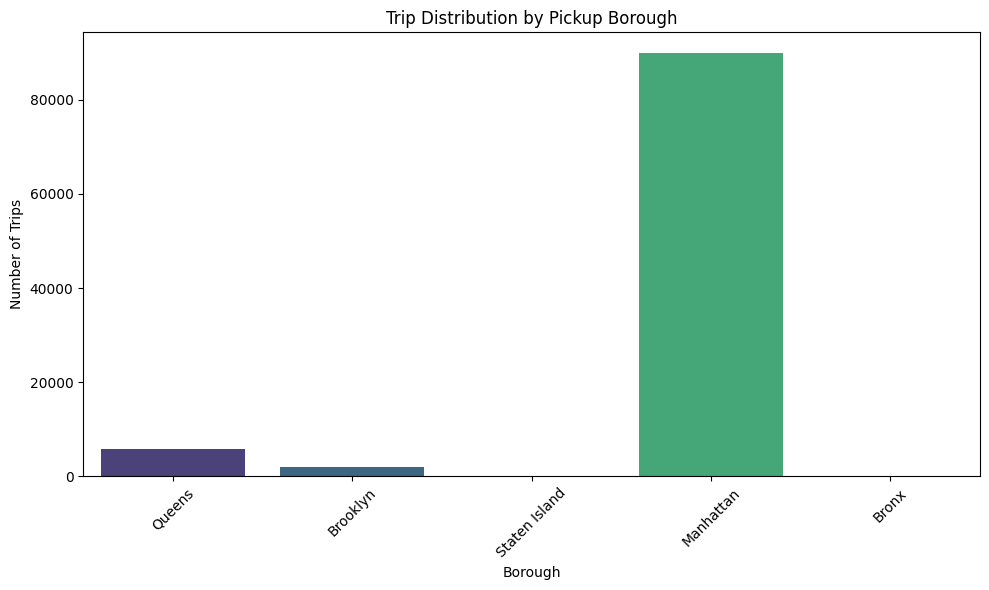

In [22]:
# Convert Spark DataFrame to Pandas DataFrame
trip_count_pd = trip_count_by_borough.toPandas()

# Plot the trip count per borough
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_borough', y='trip_count', data=trip_count_pd, palette='viridis')
plt.title('Trip Distribution by Pickup Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Average Trip Duration by Borough

In [19]:
# Average trip duration by pickup borough
avg_trip_duration_by_borough = df.groupBy("pickup_borough").agg({"trip_duration": "avg"}).withColumnRenamed("avg(trip_duration)", "avg_trip_duration")
avg_trip_duration_by_borough.show()

+--------------+------------------+
|pickup_borough| avg_trip_duration|
+--------------+------------------+
|        Queens|1367.2661870503598|
|          NULL|           658.125|
|      Brooklyn| 925.3728294177732|
| Staten Island|            1410.0|
|     Manhattan| 601.7841483229095|
|         Bronx| 609.1139240506329|
+--------------+------------------+



<ipython-input-24-853da4813be4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pickup_borough', y='avg_trip_duration', data=avg_trip_duration_pd, palette='coolwarm')


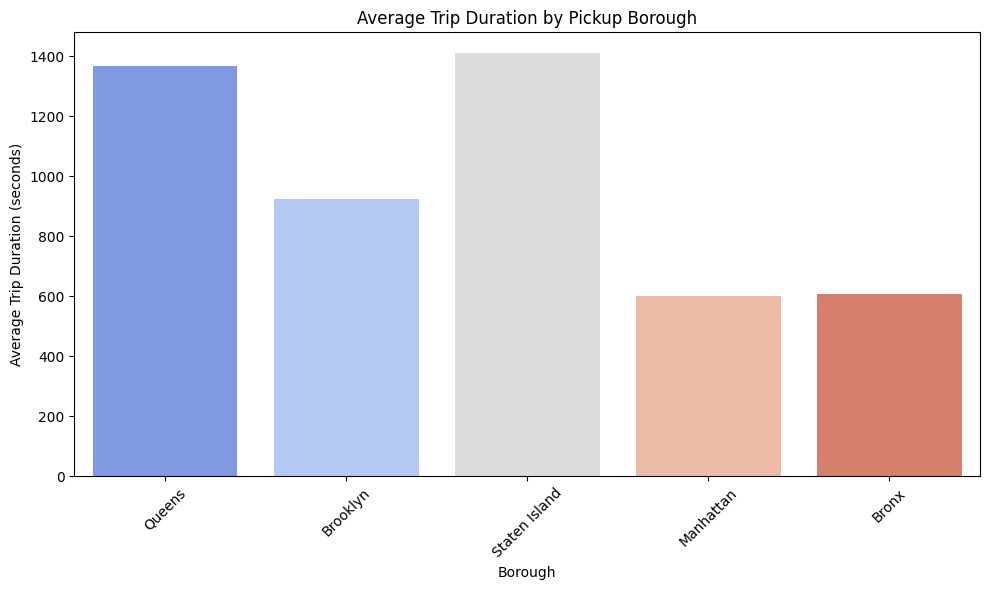

In [24]:
# Convert Spark DataFrame to Pandas DataFrame
avg_trip_duration_pd = avg_trip_duration_by_borough.toPandas()

# Plot the average trip duration per borough
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_borough', y='avg_trip_duration', data=avg_trip_duration_pd, palette='coolwarm')
plt.title('Average Trip Duration by Pickup Borough')
plt.xlabel('Borough')
plt.ylabel('Average Trip Duration (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
# Convert Spark DataFrame to Pandas DataFrame
trip_count_pd = trip_count_by_borough.toPandas()

# Plot the trip count per borough
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_borough', y='trip_count', data=trip_count_pd, palette='viridis')
plt.title('Trip Distribution by Pickup Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'trip_count_by_borough' is not defined